In [39]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [29]:
df_population = pd.read_csv('./data/us/demographics/county_populations.csv')
df_population.head()

,FIPS,total_pop,60plus
0,1001,55036,10523
1,1003,203360,53519
2,1005,26201,6150
3,1007,22580,4773
4,1009,57667,13600


In [30]:
df_icu = pd.read_csv('./data/us/hospitals/icu_county.csv')
df_icu.head()

,FIPS,hospitals,icu_beds
0,1001,1,6
1,1003,3,51
2,1005,1,5
3,1007,1,0
4,1009,1,6


In [31]:
df_beds = pd.read_csv('./data/us/hospitals/beds_by_county.csv')
df_beds = df_beds[["FIPS","staffed_beds","licensed_beds","icu_beds"]]
df_beds.head()

,FIPS,staffed_beds,licensed_beds,icu_beds
0,2020,1077,1014,60
1,2050,34,50,0
2,2070,16,16,0
3,2090,145,152,13
4,2110,45,73,9


In [32]:
df_policies = pd.read_csv('./data/us/other/policies.csv')
df_policies  = df_policies.drop([0])
df_policies.head()
#df_policies = df_policies[["FIPS","staffed_beds","licensed_beds","icu_beds"]]

,FIPS,STATE,AREA_NAME,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban
1,1000,AL,alabama,NaN,737504.0,737497.0,737500.0,737503.0,NaN,737500.0,737495.0
2,1001,AL,autauga county,NaN,737504.0,737497.0,737500.0,737503.0,NaN,737500.0,737495.0
3,1003,AL,baldwin county,NaN,737504.0,737497.0,737500.0,737503.0,NaN,737500.0,737495.0
4,1005,AL,barbour county,NaN,737504.0,737497.0,737500.0,737503.0,NaN,737500.0,737495.0
5,1007,AL,bibb county,NaN,737504.0,737497.0,737500.0,737503.0,NaN,737500.0,737495.0


### how to interpret this data?

## merge tables

In [154]:
df_all = pd.merge(df_population,df_beds,on='FIPS')
df_all = pd.merge(df_all,df_icu,on='FIPS')
df_all.head()

,FIPS,total_pop,60plus,staffed_beds,licensed_beds,icu_beds_x,hospitals,icu_beds_y
0,1001,55036,10523,55,85,6,1,6
1,1003,203360,53519,362,410,44,3,51
2,1005,26201,6150,30,74,5,1,5
3,1007,22580,4773,25,35,0,1,0
4,1009,57667,13600,25,40,6,1,6


## data normalization

In [155]:
df_train = df_all.drop(["FIPS"], axis=1)
print(df_train)
df_train = df_train.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
#print(df_train)
train_data_X = df_train.to_numpy()
#print(train_data_X)

      total_pop  60plus  staffed_beds  licensed_beds  icu_beds_x  hospitals  \
0         55036   10523            55             85           6          1   
1        203360   53519           362            410          44          3   
2         26201    6150            30             74           5          1   
3         22580    4773            25             35           0          1   
4         57667   13600            25             40           6          1   
...         ...     ...           ...            ...         ...        ...   
2478      44527    7015            74            115          10          2   
2479      22923    4298            48             48           6          1   
2480      20758    3554           105             42           6          1   
2481       8253    2206            18             18           0          1   
2482       7117    2073            12             12           0          1   

      icu_beds_y  
0              6  
1            

## PCA reduce dimensionality

[0.94594007 0.02399559]
[0.01152377 0.00029232]
[0.94594007 0.02399559]
[0.01152377 0.00029232]


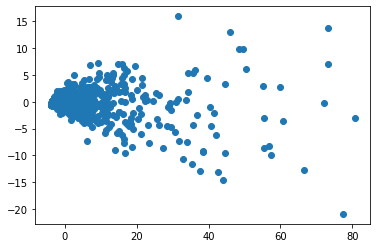

In [156]:
pca1 = PCA(n_components=2)
pca1.fit(train_data_X)
print(pca1.explained_variance_ratio_)
print(pca1.explained_variance_)

print(pca1.explained_variance_ratio_)
print(pca1.explained_variance_)

X_2d = pca1.transform(train_data_X)*100
X_in = X_2d[abs(X_2d[:,0])+abs(X_2d[:,1])<100]
plt.scatter(X_in[:,0],X_in[:,1])


[-1 -1  0 ... 15  1  1]
(2483, 3)
(1148, 3)


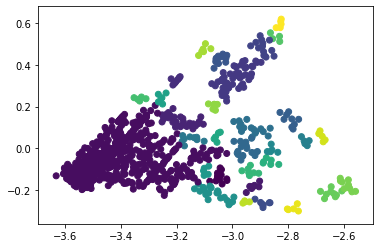

In [157]:
clustering = DBSCAN(eps=0.03, min_samples=5).fit(X_2d)
print(clustering.labels_)
#plt.plot(clustering.labels_)
tag = np.reshape(clustering.labels_,(len(clustering.labels_),1))
X_2d_tag = np.hstack((X_2d,tag))
print(X_2d_tag.shape)
X_wt_noise = X_2d_tag[X_2d_tag[:,-1]>=0]
print(X_wt_noise.shape)
plt.scatter(X_wt_noise[:,0],X_wt_noise[:,1],c=X_wt_noise[:,2].astype(float))